# Тема 6. Состоятельность и асимптотическая нормальность

In [2]:
import numpy as np
import pandas as pd
import math as mt
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import namedtuple
from tqdm import tqdm

### 1 Задание

,Superiority
n,
5,0.648
10,0.74
50,0.871
100,0.9
500,0.956


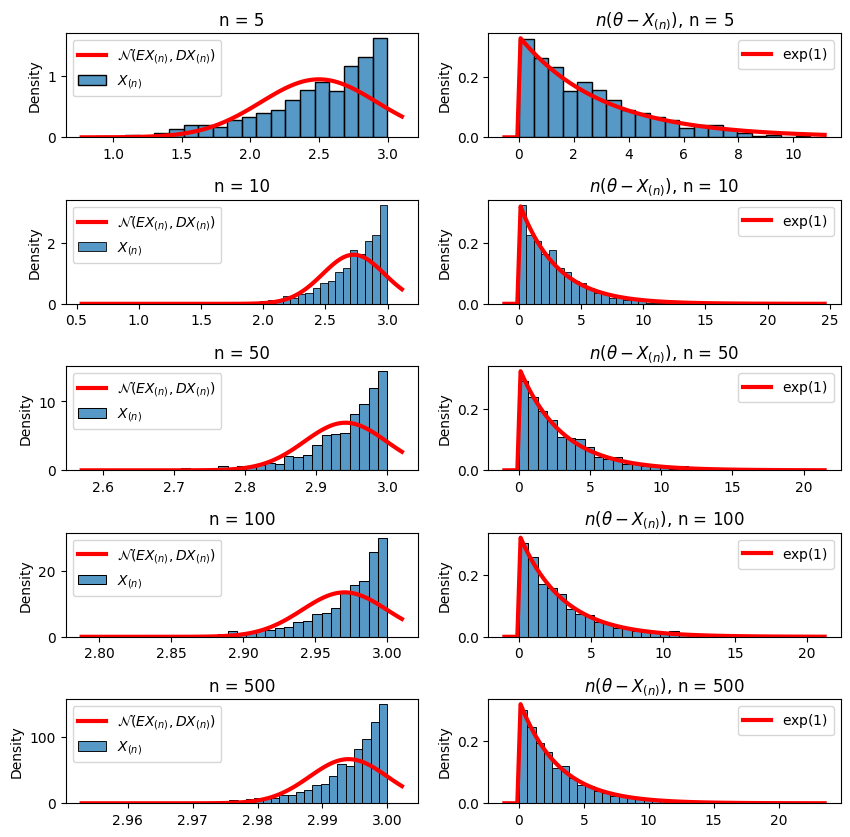

In [3]:
theta = 3
Ns = (5, 10, 50, 100, 500)
k = 1000

fig, axes = plt.subplots(len(Ns), 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.6)

df = pd.DataFrame(index=Ns, columns=["Superiority"])
df.index.name = "n"

for i, n in enumerate(Ns):
    ax1, ax2 = axes[i]
    samples = st.uniform.rvs(loc=0, scale=theta, size=(k, n))
    maximums = np.max(samples, axis=1)
    error1 = np.abs((n + 1) / n * maximums - theta)
    error2 = np.abs(2 * samples.mean(axis=1) - theta)
    superiority = np.mean(error1 < error2)
    df.at[n, "Superiority"] = superiority
    
    sns.histplot(maximums, stat='density', ax=ax1, label=r"$X_{(n)}$")
    x = np.linspace(*ax1.get_xlim(), 100)
    mean = n / (n + 1) * theta
    var = n / (n + 2) * theta**2 - mean**2
    y = st.norm.pdf(x, loc=mean,scale=mt.sqrt(var))
    ax1.plot(x, y, c='r', lw=3, label=r"$\mathcal{N}(E X_{(n)}, DX_{(n)})$")
    ax1.set_title(f"n = {n}")
    ax1.legend()

    s = n * (theta - maximums)
    sns.histplot(s, stat='density', ax=ax2)
    x = np.linspace(*ax2.get_xlim(), 100)
    y = st.expon.pdf(x, scale=1/(1/theta))
    ax2.plot(x, y, c='r', lw=3, label=r"$\exp(1)$")
    ax2.set_title(r"$n(\theta - X_{(n)})$, " + f"n = {n}")
    ax2.legend()

df

### Задание 2

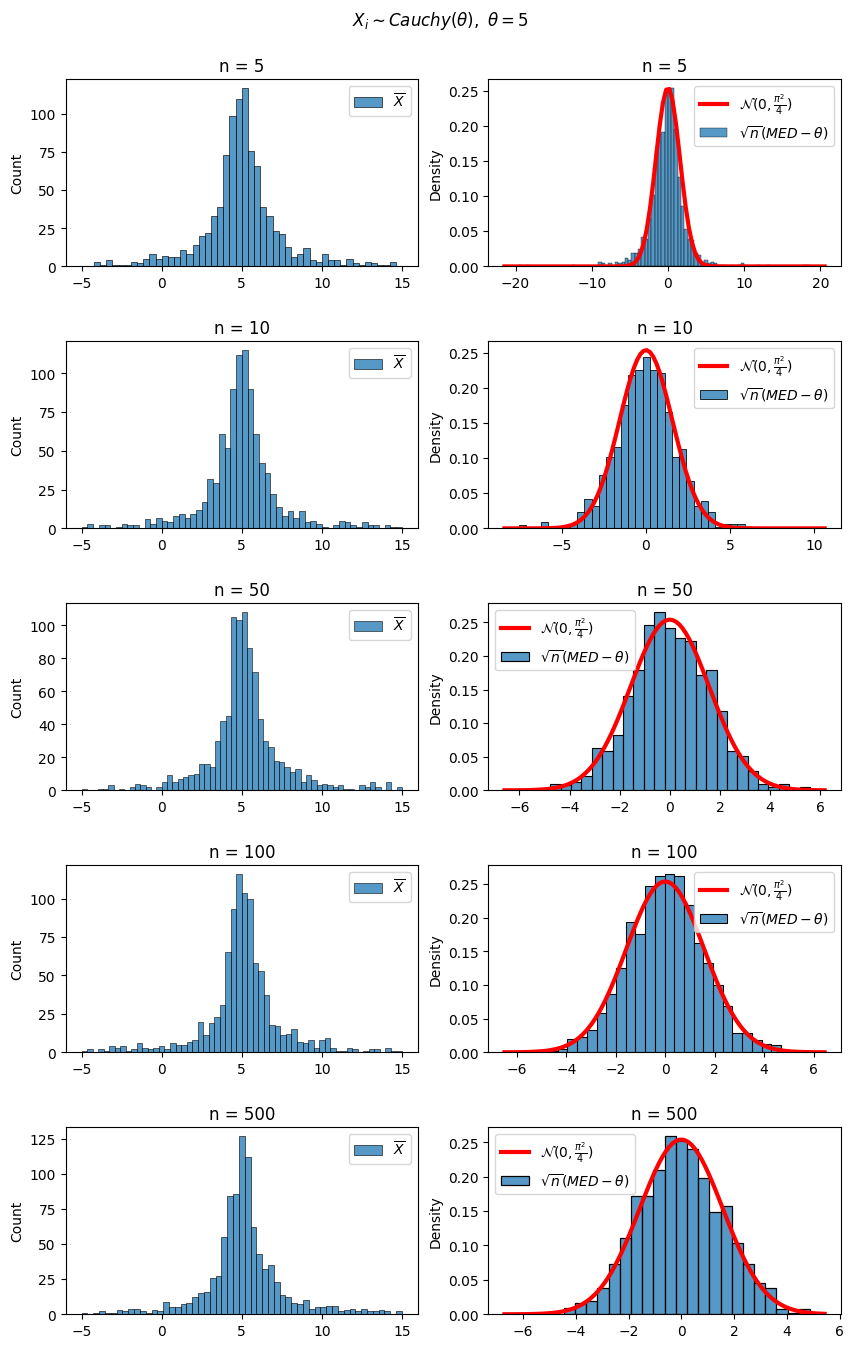

In [6]:
theta = 5
Ns = (5, 10, 50, 100, 500)
k = 1000

width, height = 2 * 5, len(Ns) * 3
fig, axes = plt.subplots(len(Ns), 2, figsize=(width, height))
fig.suptitle(fr"$X_i \sim Cauchy(\theta), \ \theta = {theta}$")
fig.subplots_adjust(top = 1 - 1/height, hspace=0.4)

for i, n in enumerate(Ns):
    ax1, ax2 = axes[i]
    samples = st.cauchy.rvs(loc=theta, size=(k, n))
    means = np.mean(samples, axis=1)
    
    sns.histplot(means, binrange=(theta - 10, theta + 10), ax=ax1, label=r"$\overline{X}$")
    ax1.set_title(f"n = {n}")
    ax1.legend()

    medians = np.median(samples, axis=1)
    s = mt.sqrt(n) * (medians - theta)
    sns.histplot(s, stat='density', ax=ax2, label=r"$\sqrt{n}(MED - \theta)$")
    x = np.linspace(*ax2.get_xlim(), 100)
    y = st.norm.pdf(x, scale=0.5*mt.pi)
    ax2.plot(x, y, c='r', lw=3, label=r"$\mathcal{N}(0, \frac{\pi^2}{4})$")
    ax2.set_title(f"n = {n}")
    ax2.legend()

### 4 Задание

In [4]:
def generate_splituniform(theta=0, shape=1):
    res = st.uniform.rvs(loc=theta-2, scale=1, size=shape)
    res += 3 * st.bernoulli.rvs(p=0.5, size=shape)
    return res

In [56]:
Task = namedtuple('Task', ['name', 'estimator', 'params'])
tasks = (
    Task(
        r"$\overline{X_{0.4}}$",
        st.trim_mean,
        (0.4,)
    ),
    Task(
        r"$MED$",
        np.median,
        ()
    )
)

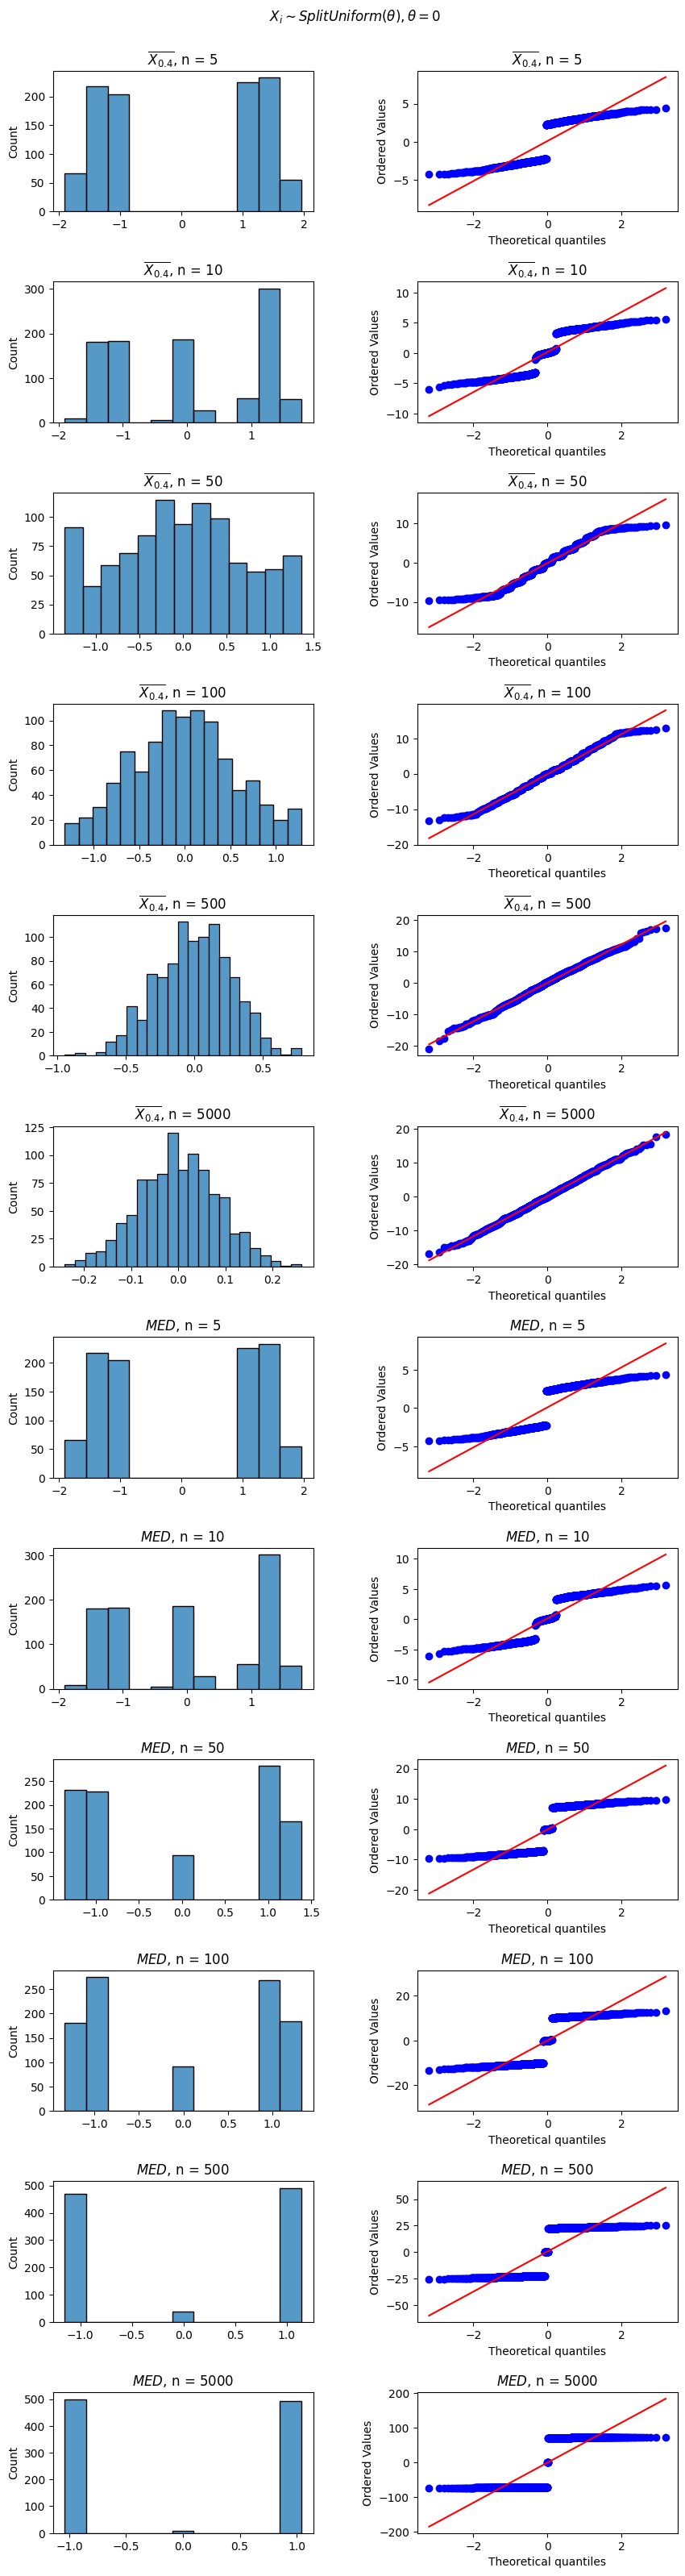

In [58]:
theta = 0
Ns = (5, 10, 50, 100, 500, 5000)
k = 1000

width, height = 2 * 5, len(tasks) * len(Ns) * 3
fig, axes = plt.subplots(len(tasks) * len(Ns), 2, figsize=(width, height))
fig.suptitle(fr"$X_i \sim SplitUniform(\theta), \theta = {theta}$")
fig.subplots_adjust(top = 1 - 1.5/height, hspace=0.5, wspace=0.4)

for i, n in enumerate(Ns):
    sample = generate_splituniform(theta, (k, n))
    for j, task in enumerate(tasks):
        ax1, ax2 = axes[len(Ns) * j + i]
        ests = task.estimator(sample, *(task.params), axis=1)

        ax1.set_title(f"{task.name}, n = {n}")
        sns.histplot(ests, ax=ax1)
        
        # sm.qqplot(mt.sqrt(n)*(ests - theta), ax=ax2)
        st.probplot(mt.sqrt(n)*(ests - theta), plot=ax2)
        ax2.set_title(f"{task.name}, n = {n}")

### 5 Задание

In [7]:
class Laplace:
    selector = st.bernoulli(0.5)
    
    def __init__(self, theta=0):
        self.theta = theta
        self.pdf = lambda x : 0.5 * mt.exp(-abs(x - theta))
        self.inv_cdfs = (
            lambda y: mt.log(y) + theta,
            lambda y: -mt.log(y) + theta
        )
    
    def rvs(self, shape=1):
        distr_inds = Laplace.selector.rvs(shape)
        u = st.uniform.rvs(size=shape)
        result = [self.inv_cdfs[i](y) for i, y in zip(np.nditer(distr_inds), np.nditer(u))]
        result = np.array(result).reshape(shape)
        return result

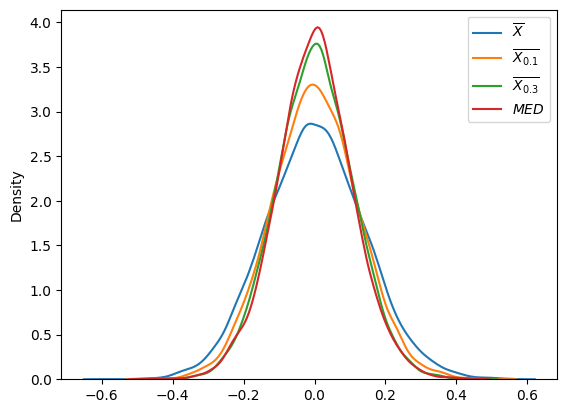

In [8]:
n = 100
k = 10000
theta = 0
rv = Laplace(theta)
estimators = (
    (
        r"$\overline{X}$",
        np.mean,
        ()
    ),
    (
        r"$\overline{X_{0.1}}$",
        st.trim_mean,
        (0.1,)
    ),
    (
        r"$\overline{X_{0.3}}$",
        st.trim_mean,
        (0.3,)
    ),
        (
        r"$MED$",
        np.median,
        ()
    )
)

fig = plt.figure()
ax = fig.add_subplot()

samples = rv.rvs((k, n))

for name, estimator, params in estimators:
    s = estimator(samples, *params, axis=1)
    sns.kdeplot(s, ax=ax, label=name)
    ax.legend()